# Drug Review

In this project, the grading machine will be created. This machine will read reviews from patients, and the outputs will be the rating that patients rated. There are four levels of scores, namely, bad (0), moderate (1), good (2), excellent (3). The machine is made from the recurrent neural network, known as LSTM. 

## Data Preprocessing

### Importing the libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [0]:
#!pip install tensorflow==2.00-beta0

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
root_path = "drive/My Drive/Drug_review"

### Importing the dataset

In [0]:
Train = pd.read_csv(root_path+'/TrainingData.tsv',delimiter='\t')

In [0]:
Test = pd.read_csv(root_path+'/TestData.tsv', delimiter = '\t')

In [9]:
len(Train)

161297

The number of sample is equal to 161297.

In [10]:
len(Test)

53766

The number of test set is equal to 53766.

In [11]:
Train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [12]:
Test.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


### Selecting the data

The review and rating columns will be selected from the whole columns of the dataset.

In [0]:
Train = Train[['review','rating']]
Test = Test[['review','rating']]

In [14]:
Train.head()

,review,rating
0,"""It has no side effect, I take it in combinati...",9.0
1,"""My son is halfway through his fourth week of ...",8.0
2,"""I used to take another oral contraceptive, wh...",5.0
3,"""This is my first time using any form of birth...",8.0
4,"""Suboxone has completely turned my life around...",9.0


### Creating a function that cleans texts

In [0]:
import re

In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm","i am",text)
    text = re.sub(r"he's","he is",text)
    text = re.sub(r"she's","she is",text)
    text = re.sub(r"that's","that is",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"where's","where is",text)
    text = re.sub(r"\'ll"," will",text)
    text = re.sub(r"\'ve"," have",text)
    text = re.sub(r"\'re"," are",text)
    text = re.sub(r"\'d'"," would",text)
    text = re.sub(r"can't","cannot",text)
    text = re.sub(r"can't","cannot",text)
    text = re.sub(r"[-()\"#/@;:<>{}+=~|.?,]", "", text)
    return text

### Applying the clean_text function to the data

In [0]:
Train_data = Train.copy()
Test_data = Test.copy()

In [0]:
Train_data['review']=Train_data['review'].apply(clean_text)

In [19]:
Train_data.head()

,review,rating
0,it has no side effect i take it in combination...,9.0
1,my son is halfway through his fourth week of i...,8.0
2,i used to take another oral contraceptive whic...,5.0
3,this is my first time using any form of birth ...,8.0
4,suboxone has completely turned my life around ...,9.0


### Looking at the distribution of rating

There are ten ratings in the traning set and test set.

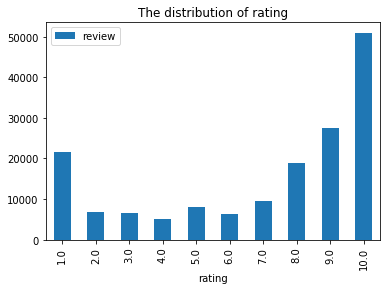

In [20]:
axis_rating = Train_data.groupby('rating').count().plot.bar()
axis_rating.set_title('The distribution of rating');

In [21]:
Train_data.groupby('rating').count()

,review
rating,
1.0,21619
2.0,6931
3.0,6513
4.0,5012
5.0,8013
6.0,6343
7.0,9456
8.0,18890
9.0,27531


Now, we would like to classify the rating score into 4 categories.

1 - 3 = Bad, this will be scored 0.

4 - 7 = Moderate, this will be scored 1.

8 - 9 = Good, this will be scored 2.

10 = Excellent, this will be scored 3.


### Creating a function to define a score following the above criterion.

In [0]:
def rating2score(rating):
    if rating <=3:
        score = 0
    elif rating <=7:
        score = 1
    elif rating <=9:
        score = 2
    else:
        score = 3
    return score

In [0]:
Train_data['score']=Train_data['rating'].apply(rating2score)

In [24]:
Train_data.groupby('score')['review'].count()

score
0    35063
1    28824
2    46421
3    50989
Name: review, dtype: int64

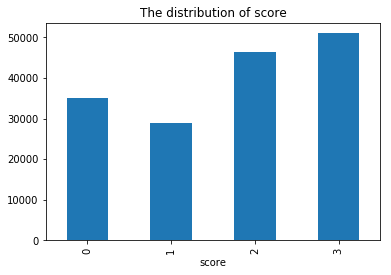

In [25]:
axis_score = Train_data.groupby('score')['review'].count().plot.bar()
axis_score.set_title('The distribution of score');

### Creating a function that returns a number of words in the reviews.

In [0]:
def wordcount(text):
    return len(text.split())

In [0]:
Train_data['word_count'] = Train_data['review'].apply(wordcount)

### Looking at a histogram of word counting at each review

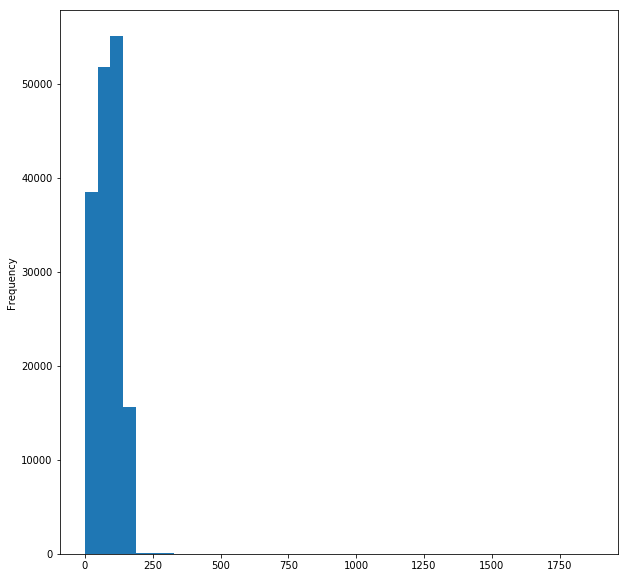

In [28]:
plt.figure(figsize=(10,10))
axis_hist = Train_data['word_count'].plot.hist(bins=40)

Most of reviews have word counts less than 64 words. The reviews with word counts greater than 200 will be fittered out.

In [0]:
Train_data = Train_data[Train_data['word_count']<=128]

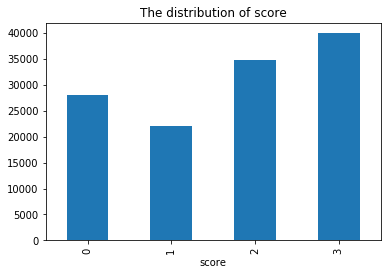

In [30]:
axis_score1 = Train_data.groupby('score')['review'].count().plot.bar()
axis_score1.set_title('The distribution of score');

In [31]:
len(Train_data)

124680

Now there are 161042 training data.

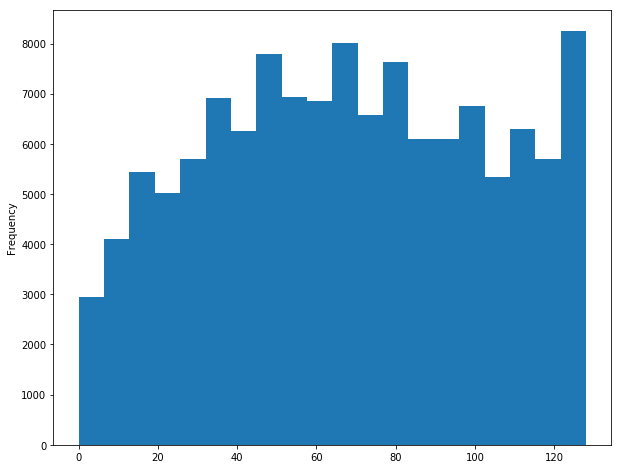

In [32]:
plt.figure(figsize=(10,8))
axis_hist2 = Train_data['word_count'].plot.hist(bins=20)

In [0]:
from tensorflow.keras.preprocessing import text,sequence

For this project, 50-dimensional GloVe vectors will be used to represent words.

### Using pretrain GloVe with 50 dimensions

In [0]:
import os
word2vec_map = {}
with open(os.path.join(root_path,'glove.6B.50d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word2vec_map[word] = coefs

In [35]:
len(word2vec_map)

400000

In [36]:
word2vec_map.get('the')

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

### Setting the threshold

This is the maximum number of word that will be used in this project.

In [0]:
Top_word = 20000

This is the maximum number of words per sentence.

In [0]:
max_word_count = 128

In [0]:
X_train = Train_data['review']
y_train = Train_data['score']

### Create a dictionary that transforms words into interger numbers with training texts.

In [0]:
tokenizer = text.Tokenizer(num_words = Top_word, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

### Vectorizing training texts.

In [0]:
X_train_token = tokenizer.texts_to_sequences(X_train)

### Fix sequence length to max value. 
Sequences shorter than the length are padded in the beginning and sequences longer are truncated at the beginning.

In [0]:
max_length = 128
X_train_token = sequence.pad_sequences(X_train_token, maxlen=max_length,padding='post', truncating='post')

### Dictionary that transfroms words into indices

In [0]:
word2index = tokenizer.word_index

### Dictionary that transforms indices into words

In [0]:
index2word = {index:word for word,index in word2index.items()}

In [45]:
len(word2index)

63754

### preparing embedding matrix



In [0]:
num_words = min(Top_word, len(word2index))+1
emb_dim = 50

In [0]:
embedding_matrix = np.zeros((num_words, emb_dim))
for word, i in word2index.items():
    if i > Top_word:
        continue
    embedding_vector = word2vec_map.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Creating a function that apply the data preprocessing steps to the test set

In [0]:
def DataPreprocessing(data, tokenizer):
    #Cleaning text
    data['review']=data['review'].apply(clean_text)
    #Calculating score
    data['score']=data['rating'].apply(rating2score)
    #Calculating word count
    data['word_count']=data['review'].apply(wordcount)
    #Keeping the data that have word count less than or equal 200
    data = data[data['word_count']<=128]
    
    #Feature selection
    X = data['review']
    #Target selection
    y = data['score']
    
    #Transfroming X to a sequence of interger numbers
    data_token = tokenizer.texts_to_sequences(X)
    #Padding
    data_token = sequence.pad_sequences(data_token, maxlen=max_length,padding='post', truncating='post')
    
    return data_token, y

In [49]:
Test_data.head()

,review,rating
0,"""I&#039;ve tried a few antidepressants over th...",10.0
1,"""My son has Crohn&#039;s disease and has done ...",8.0
2,"""Quick reduction of symptoms""",9.0
3,"""Contrave combines drugs that were used for al...",9.0
4,"""I have been on this birth control for one cyc...",9.0


### Performing the data preprocessing function to the test set

In [0]:
X_test_token, y_test = DataPreprocessing(Test_data,tokenizer)

In [51]:
len(X_test_token)

41538

## Creating the sepCNN that returns the score

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SeparableConv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.initializers import Constant
from tensorflow.keras import regularizers

### Initiating the Sentiment Classification

In [0]:
predictor = Sequential()

### The 1st Layer - The Embedding Layer

In [0]:
input_shape = 128
dropout_rate = 0.4

In [0]:
predictor.add(Embedding(input_dim=num_words,
                        output_dim=emb_dim,
                        input_length=input_shape,
                        embeddings_initializer=Constant(embedding_matrix),
                        trainable=False, name = "Embedding"
                       ))

### The 2nd Layer - The 1st LSTM layer with dropout

In [0]:
predictor.add(LSTM(units=64, return_sequences=True, name = 'LSTM_1'))

In [0]:
predictor.add(Dropout(rate=dropout_rate, name = 'Dropout_1'))

### The 3rd Layer - The 2nd LSTM layer with dropout

In [0]:
predictor.add(LSTM(units=128, return_sequences=False, name = 'LSTM_2'))

In [0]:
predictor.add(Dropout(rate=dropout_rate, name = 'Dropout_2'))

### The 4th layer - The Fully Connected Layer

In [0]:
predictor.add(Dense(64, activation = 'relu', name = 'FC_1'))

In [0]:
predictor.add(Dropout(rate=dropout_rate, name = 'Dropout_3'))

### The Last Layer - The Output Layer

There 4 outcomes in this project. The activation function will be the softmax function.

In [0]:
predictor.add(Dense(4, activation='softmax', name = 'Output_Softmax'))

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
adam = Adam(lr=0.0000005)

In [0]:
predictor.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

### Summary

In [100]:
predictor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 128, 50)           1000050   
_________________________________________________________________
LSTM_1 (LSTM)                (None, 128, 64)           29440     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
LSTM_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
Dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
FC_1 (Dense)                 (None, 64)                8256      
_________________________________________________________________
Dropout_3 (Dropout)          (None, 64)                0

In [0]:
from tensorflow.keras.models import load_model
#predictor = load_model(os.path.join(root_path,'drugreview1_06.h5'))
predictor.load_weights(os.path.join(root_path,'drugreview1_07_weights.h5'))

In [106]:
predictor.fit(x=X_train_token,y=y_train,
             batch_size=1024,
             epochs=30,
             validation_data=(X_test_token,y_test)
             )

Train on 124680 samples, validate on 41538 samples
Epoch 1/30
124680/124680 [==============================] - 58s 467us/sample - loss: 0.5099 - acc: 0.8207 - val_loss: 0.9828 - val_acc: 0.7289
Epoch 2/30
124680/124680 [==============================] - 58s 465us/sample - loss: 0.5145 - acc: 0.8184 - val_loss: 0.9824 - val_acc: 0.7287
Epoch 3/30
124680/124680 [==============================] - 58s 464us/sample - loss: 0.5109 - acc: 0.8186 - val_loss: 0.9825 - val_acc: 0.7287
Epoch 4/30
124680/124680 [==============================] - 58s 463us/sample - loss: 0.5079 - acc: 0.8202 - val_loss: 0.9826 - val_acc: 0.7286
Epoch 5/30
124680/124680 [==============================] - 57s 458us/sample - loss: 0.5117 - acc: 0.8190 - val_loss: 0.9827 - val_acc: 0.7284
Epoch 6/30
124680/124680 [==============================] - 58s 462us/sample - loss: 0.5118 - acc: 0.8185 - val_loss: 0.9824 - val_acc: 0.7283
Epoch 7/30
124680/124680 [==============================] - 57s 459us/sample - loss: 0.5164

In [107]:
predictor.save(os.path.join(root_path,'drugreview1_08.h5'))
predictor.save_weights(os.path.join(root_path,'drugreview1_08_weights.h5'))
print("Model has been saved")

Model has been saved


In [108]:
predictor.evaluate(X_test_token,y_test)

41538/41538 [==============================] - 207s 5ms/sample - loss: 0.9807 - acc: 0.7282


[0.9807373537499087, 0.7281525]

## Summary
The accuracy of the model is about 73% on testing set. There are ways to improve the model. The first one is to increase the number of LSTM cells in the first layer and the second layer. The second one is to have more layer of LSTM cells. The third way is to increase the number of fully connected layer.